In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product
import json, joblib, torch

In [2]:
df = pd.read_csv("/Users/ijongseung/Demadn-Quadratic-Tilting/power_demand_final.csv")
df["일시"] = pd.to_datetime(df["일시"])
df["holiday_name"].fillna("non-event", inplace=True)

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_70416/27962554.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["holiday_name"].fillna("non-event", inplace=True)


In [3]:
import statsmodels.api as sm
import numpy as np

# 1. 학습(train) 데이터만 사용해서 추세 추정
train = df[df["일시"] <= "2022-12-31 23:00:00"]

t_train = np.arange(len(train))
X_train = sm.add_constant(t_train)

# 로그-선형 추세 적합
trend_model = sm.OLS(np.log(train["power demand(MW)"]), X_train).fit()

# 2. 전체 데이터에 대해 추세 예측
t_all = np.arange(len(df))
X_all = sm.add_constant(t_all)

trend_hat_log = trend_model.predict(X_all)   # 로그 스케일 추세
trend_hat_exp = np.exp(trend_hat_log)        # 원 단위 추세

# 3. 데이터프레임에 추가
df["trend"] = trend_hat_exp
df["detrend"] = df["power demand(MW)"] - df["trend"]   # 추세 제거 (원 단위)


## 푸리에

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product

# 대상: detrend
y_all = df["detrend"].values   # 로그 스케일에서 계절성 추출
t_all = np.arange(len(y_all))

# Fourier term 생성
def generate_fourier_terms(timesteps, period, K):
    terms = []
    for k in range(1, K + 1):
        terms.append(np.sin(2 * np.pi * k * timesteps / period))
        terms.append(np.cos(2 * np.pi * k * timesteps / period))
    return np.stack(terms, axis=1)

# 탐색할 K 값
daily_K_vals  = [1,2,3]
weekly_K_vals = [1,2,3,4,5,6,7,8]
yearly_K_vals = [1,2,3,4]

best_mse = float("inf")
best_model, best_X_all, best_K_combo = None, None, None

# 학습/검증 분할
val = df[(df["일시"] > "2022-12-31 23:00:00") & (df["일시"] <= "2023-12-31 23:00:00")]
train_end = len(train)
val_end   = train_end + len(val)

for Kd, Kw, Ky in product(daily_K_vals, weekly_K_vals, yearly_K_vals):
    X_all = np.hstack([
        generate_fourier_terms(t_all, 24, Kd),          # 1일
        generate_fourier_terms(t_all, 24*7, Kw),        # 1주
        generate_fourier_terms(t_all, 24*365.25, Ky)    # 1년
    ])
    X_train = X_all[:train_end]
    X_val   = X_all[train_end:val_end]
    y_train = y_all[:train_end]
    y_val   = y_all[train_end:val_end]

    model = LinearRegression().fit(X_train, y_train)
    val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, val_pred)

    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_X_all = X_all
        best_K_combo = (Kd, Kw, Ky)

# 최적 모델로 전체 예측
seasonality_pred_log = best_model.predict(best_X_all)

# df["seasonality_log"] = seasonality_pred_log
df["seasonality"] = seasonality_pred_log   # 원 단위 계절성

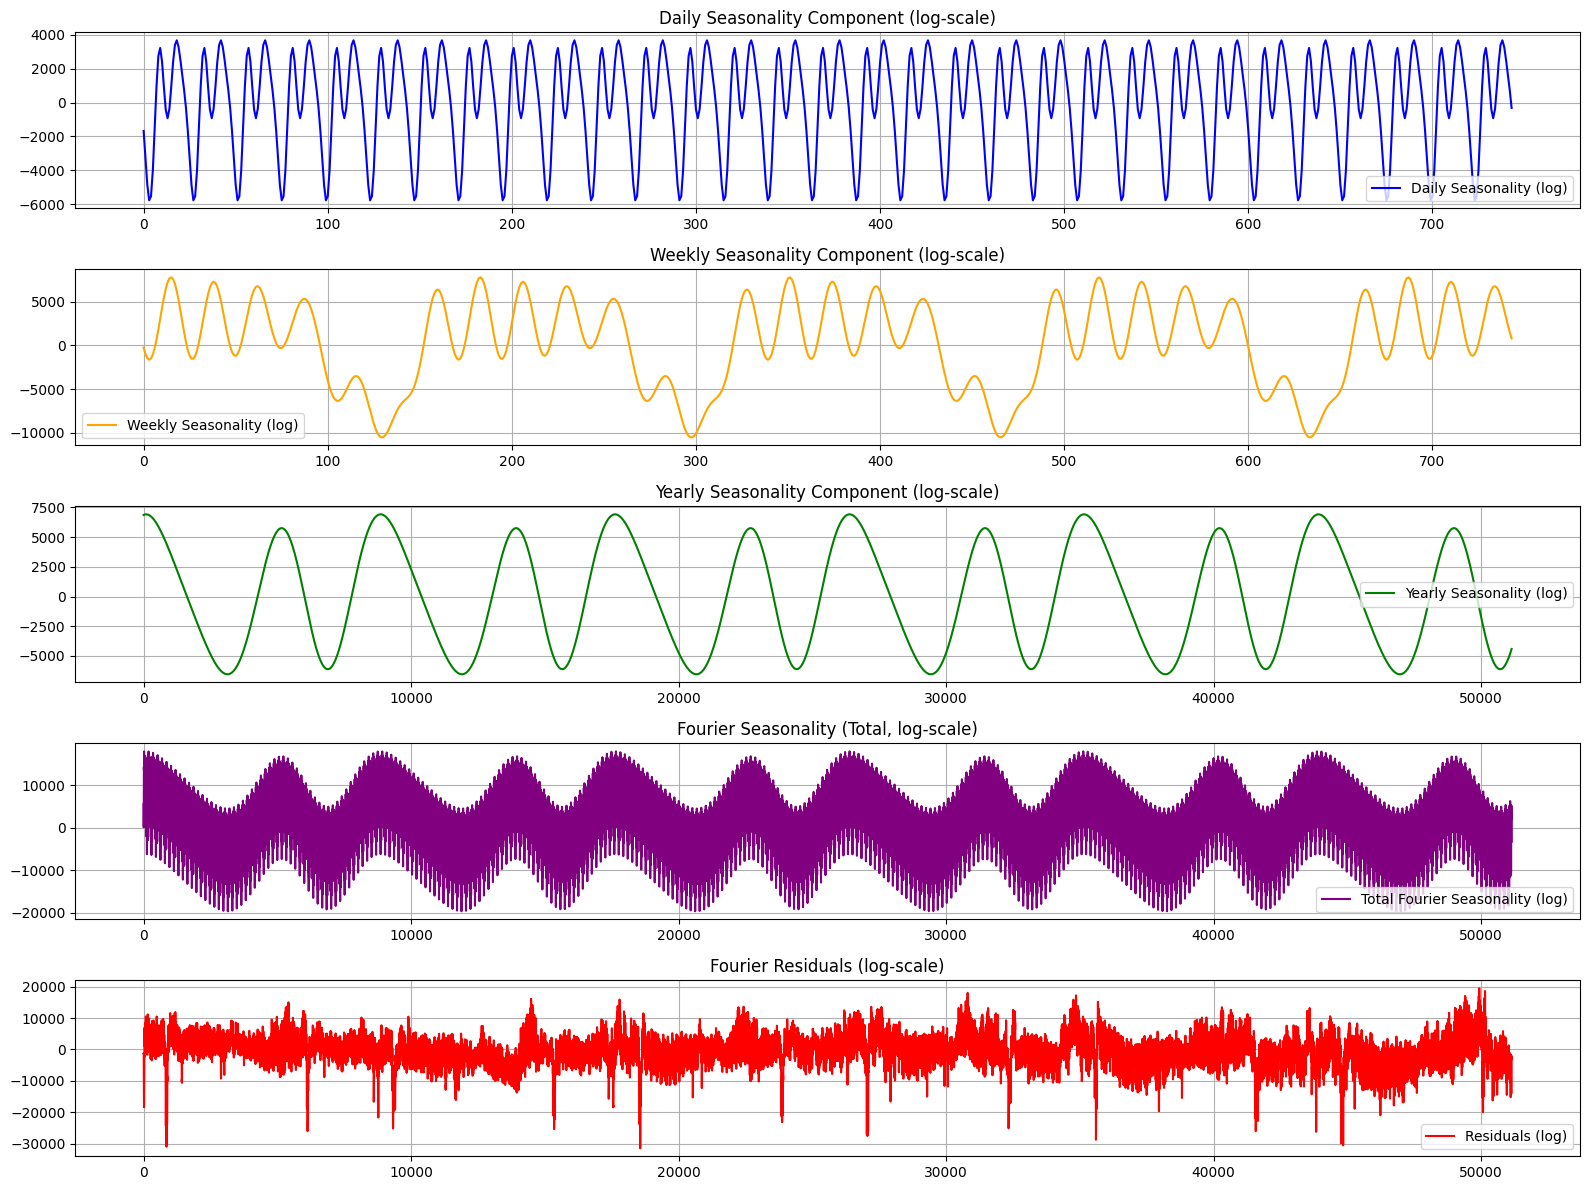

In [5]:
# --- 1. 시간 인덱스 보정 ---
if "t" not in df.columns:
    df["t"] = np.arange(len(df))

df_result = df.copy()

# --- 2. 최적 K ---
Kd, Kw, Ky = best_K_combo

# --- 3. Fourier term 생성 (로그 공간) ---
daily_terms  = generate_fourier_terms(t_all, 24, Kd)          
weekly_terms = generate_fourier_terms(t_all, 24*7, Kw)     
yearly_terms = generate_fourier_terms(t_all, 24*365.25, Ky)

coef = best_model.coef_

# --- 4. 각 성분 분리 (로그 공간) ---
daily_pred_log  = daily_terms @ coef[:2*Kd]
weekly_pred_log = weekly_terms @ coef[2*Kd:2*Kd + 2*Kw]
yearly_pred_log = yearly_terms @ coef[2*Kd + 2*Kw:]

# --- 5. 전체 seasonality & 잔차 (로그 공간) ---
seasonality_pred_log = best_model.predict(best_X_all)
residuals_log = y_all - seasonality_pred_log   # 로그 잔차

df_result["Fourier_Seasonality"] = seasonality_pred_log
df_result["Fourier_Residual"]    = residuals_log

# --- 6. 시각화 ---
plt.figure(figsize=(16, 12))

# 1. 일간 성분
plt.subplot(5, 1, 1)
plt.plot(df_result["t"][:24*31], daily_pred_log[:24*31], label="Daily Seasonality (log)", color='blue')
plt.title("Daily Seasonality Component (log-scale)")
plt.grid(True)
plt.legend()

# 2. 주간 성분
plt.subplot(5, 1, 2)
plt.plot(df_result["t"][:24*31], weekly_pred_log[:24*31], label="Weekly Seasonality (log)", color='orange')
plt.title("Weekly Seasonality Component (log-scale)")
plt.grid(True)
plt.legend()

# 3. 연간 성분
plt.subplot(5, 1, 3)
plt.plot(df_result["t"], yearly_pred_log, label="Yearly Seasonality (log)", color='green')
plt.title("Yearly Seasonality Component (log-scale)")
plt.grid(True)
plt.legend()

# 4. 전체 Fourier seasonality
plt.subplot(5, 1, 4)
plt.plot(df_result["t"], df_result["Fourier_Seasonality"], label="Total Fourier Seasonality (log)", color='purple')
plt.title("Fourier Seasonality (Total, log-scale)")
plt.grid(True)
plt.legend()

# 5. 잔차
plt.subplot(5, 1, 5)
plt.plot(df_result["t"], df_result["Fourier_Residual"], label="Residuals (log)", color='red')
plt.title("Fourier Residuals (log-scale)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Component  Harmonic k         aₖ         bₖ  Amplitude  Phase (rad)  Phase (deg)
    Daily           1 -2212.8022 -1781.1312  2840.5848      -2.4639      -141.17
    Daily           2 -2420.9742 -1044.9087  2636.8447      -2.7341      -156.65
    Daily           3   410.8001  1149.5745  1220.7695       1.2276        70.34
   Weekly           1  5040.5098   195.6898  5044.3070       0.0388         2.22
   Weekly           2   -44.5713  2981.1314  2981.4645       1.5857        90.86
   Weekly           3  -936.7227   327.8799   992.4489       2.8049       160.71
   Weekly           4  -733.4400   187.7111   757.0797       2.8910       165.64
   Weekly           5  -880.0201 -1118.5974  1423.2693      -2.2374      -128.19
   Weekly           6  1341.1846  -800.3596  1561.8424      -0.5380       -30.83
   Weekly           7 -2212.8022 -1781.1312  2840.5848      -2.4639      -141.17
   Weekly           8 -1239.6691  -246.0148  1263.8445      -2.9457      -168.78
   Yearly           1  -776.

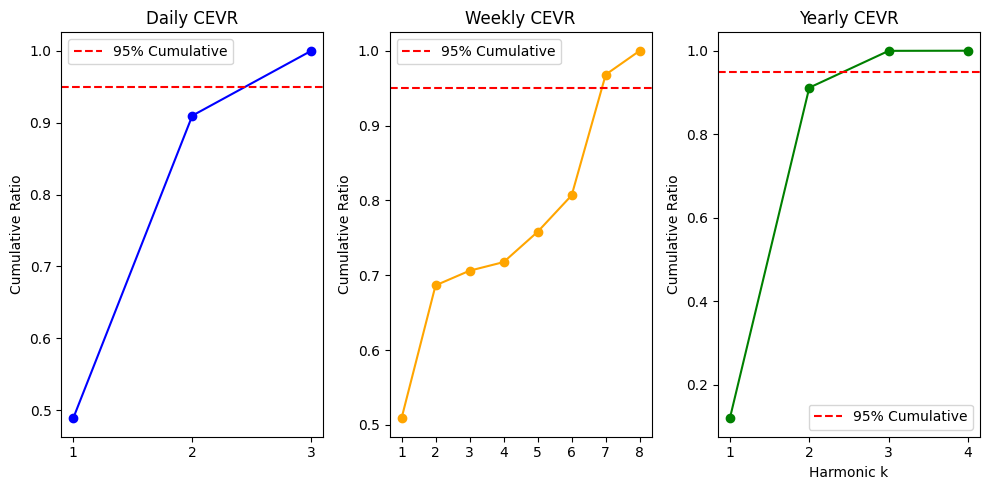

In [6]:
def extract_amplitude_phase(coef_block, K, label):
    results = []
    for k in range(K):
        a_k = coef_block[2 * k]
        b_k = coef_block[2 * k + 1]
        amplitude = np.sqrt(a_k**2 + b_k**2)
        phase_rad = np.arctan2(b_k, a_k)
        phase_deg = np.degrees(phase_rad)
        results.append({
            "Component": label,
            "Harmonic k": k + 1,
            "aₖ": round(a_k, 4),
            "bₖ": round(b_k, 4),
            "Amplitude": round(amplitude, 4),
            "Phase (rad)": round(phase_rad, 4),
            "Phase (deg)": round(phase_deg, 2)
        })
    return results

# 최적 K
Kd, Kw, Ky = best_K_combo
coef = best_model.coef_

# 계수 분할
daily_coef   = coef[:2 * Kd]
weekly_coef  = coef[2 * Kd : 2 * Kd + 2 * Kw]
yearly_coef  = coef[2 * Kd + 2 * Kw:]

# 해석 실행
daily_info  = extract_amplitude_phase(daily_coef,  Kd, "Daily")
weekly_info = extract_amplitude_phase(weekly_coef, Kw, "Weekly")
yearly_info = extract_amplitude_phase(yearly_coef, Ky, "Yearly")

# 결과 통합
seasonality_df = pd.DataFrame(daily_info + weekly_info + yearly_info)

# 시각 또는 테이블 출력

print(seasonality_df.to_string(index=False))

# 누적 설명력 계산

def confidential_test(data, component):
    # 필터링 
    data = data[data["Component"]==component]
    energy = data["aₖ"].values**2 + data["bₖ"].values**2

    total_energy = np.sum(energy)
    cumulative_ratio = np.cumsum(energy) / total_energy

    print("누적 설명력:", np.round(cumulative_ratio, 4))

    return np.round(cumulative_ratio, 4)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

# 각각의 누적 설명력 시리즈 생성
daily = confidential_test(seasonality_df, "Daily")
weekly = confidential_test(seasonality_df, "Weekly")
yearly = confidential_test(seasonality_df, "Yearly")

# Subplot 설정 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=False)

# 공통: x축 눈금을 정수로 고정
for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# 1. Daily
axes[0].plot(np.arange(1, len(daily)+1), daily, marker='o', color='blue')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[0].set_title("Daily CEVR")
axes[0].set_ylabel("Cumulative Ratio")
axes[0].legend()

# 2. Weekly
axes[1].plot(np.arange(1, len(weekly)+1), weekly, marker='o', color='orange')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[1].set_title("Weekly CEVR")
axes[1].set_ylabel("Cumulative Ratio")
axes[1].legend()

# 3. Yearly
axes[2].plot(np.arange(1, len(yearly)+1), yearly, marker='o', color='green')
axes[2].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[2].set_title("Yearly CEVR")
axes[2].set_xlabel("Harmonic k")
axes[2].set_ylabel("Cumulative Ratio")
axes[2].legend()

plt.tight_layout()
plt.show()


In [7]:
train = df_result[df_result["일시"]<="2022-12-31 23:00:00"]
val = df_result[(df_result["일시"]>"2022-12-31 23:00:00") & (df["일시"]<="2023-12-31 23:00:00")]
test = df_result[df_result["일시"]>"2023-12-31 23:00:00"]

### Seq2Seq-LSTM

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from typing import Optional

# =========================================================
# 1) Dataset (일 단위 stride, 패딩+마스크, 빈 타깃 제외)
# =========================================================
class DailyStepDataset(Dataset):
    """
    - in_days: 입력 일 수 (정수)
    - out_days: 예측 일 수 (정수)
    - stride: 하루(24h) 고정 이동
    - feature_cols: 모델 입력에 쓸 모든 피처 (X)
    - target_col: 예측 대상 단일 컬럼명 (y)
    - scaler_X, scaler_y: 반드시 train으로만 fit해서 전달
    - pad_strategy: "zero" | "edge"
    - include_head_tail: True면 시계열 헤드/테일도 윈도우 생성(패딩으로 보정)
    - exclude_empty_targets: 타깃 마스크 합이 0인 샘플 제거
    """
    def __init__(self, df, feature_cols, target_col,
                 in_days, out_days, scaler_X, scaler_y,
                 pad_value=0.0, pad_strategy="zero",
                 include_head_tail=False,
                 exclude_empty_targets=True):
                 
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.in_len = int(in_days) * 24
        self.out_len = int(out_days) * 24
        self.stride = 24

        Xs = scaler_X.transform(df[feature_cols].values)
        ys = scaler_y.transform(df[[target_col]].values).flatten()
        self.X = torch.tensor(Xs, dtype=torch.float32)
        self.y = torch.tensor(ys, dtype=torch.float32)

        self.T = len(self.X)
        self.pad_value = float(pad_value)
        self.pad_strategy = pad_strategy

        if include_head_tail:
            start_min = -(self.in_len - 1)
            start_max = self.T - 1
        else:
            start_min = 0
            start_max = self.T - self.in_len - self.out_len
        starts = list(range(start_min, start_max + 1, self.stride))

        # 필요 시 빈 타깃 샘플 제거
        if exclude_empty_targets:
            filtered = []
            for s in starts:
                out_start, out_end = s + self.in_len, s + self.in_len + self.out_len - 1
                real_out_s, real_out_e = max(out_start, 0), min(out_end, self.T - 1)
                y_real_len = max(0, real_out_e - real_out_s + 1)
                if y_real_len > 0:
                    filtered.append(s)
            self.starts = filtered
        else:
            self.starts = starts

    def __len__(self):
        return len(self.starts)

    def _left_pad(self, arr, need, feat=False):
        if need <= 0:
            return arr
        if self.pad_strategy == "edge" and len(arr) > 0:
            pad_val = arr[0:1] if not feat else arr[0:1, :]
            pad = pad_val.repeat(need, 1) if feat else pad_val.repeat(need)
        else:
            shape = (need, arr.shape[1]) if feat else (need,)
            pad = torch.full(shape, self.pad_value, dtype=arr.dtype)
        return torch.cat([pad, arr], dim=0)

    def _right_pad(self, arr, need):
        if need <= 0:
            return arr
        if self.pad_strategy == "edge" and len(arr) > 0:
            pad_val = arr[-1:]
            pad = pad_val.repeat(need)
        else:
            pad = torch.full((need,), self.pad_value, dtype=arr.dtype)
        return torch.cat([arr, pad], dim=0)

    def __getitem__(self, idx):
        s = self.starts[idx]
        in_start, in_end = s, s + self.in_len - 1
        out_start, out_end = s + self.in_len, s + self.in_len + self.out_len - 1

        # 입력 X 윈도우 (좌패딩 가능)
        real_in_s, real_in_e = max(in_start, 0), min(in_end, self.T - 1)
        x_part = self.X[real_in_s:real_in_e+1]
        left_need = real_in_s - in_start
        x_seq = self._left_pad(x_part, left_need, feat=True)

        # 타깃 y 윈도우 (우패딩/좌패딩 모두 가능)
        real_out_s, real_out_e = max(out_start, 0), min(out_end, self.T - 1)
        y_part = self.y[real_out_s:real_out_e+1] if real_out_s <= real_out_e else torch.empty(0)
        right_need = out_end - real_out_e
        y_seq = self._right_pad(y_part, right_need)
        if len(y_seq) < self.out_len:  # 헤드 구간은 좌패딩 필요할 수 있음
            y_seq = self._left_pad(y_seq, self.out_len - len(y_seq), feat=False)

        # 마스크: 실제 관측된 타깃 위치 = 1.0
        y_mask = torch.zeros(self.out_len, dtype=torch.float32)
        y_real_len = max(0, real_out_e - real_out_s + 1)
        if y_real_len > 0:
            left_pad_len = max(0, real_out_s - out_start)
            y_mask[left_pad_len:left_pad_len + y_real_len] = 1.0

        # 디코더 시작용 y0_prev (인코더 마지막 시점의 실제값 또는 pad_value)
        y0_idx = in_end
        if 0 <= y0_idx < self.T:
            y0_prev = self.y[y0_idx]
        else:
            y0_prev = torch.tensor(self.pad_value, dtype=self.y.dtype)

        return x_seq, y_seq.unsqueeze(-1), y_mask, y0_prev


# =========================================================
# 2) 모델 (Seq2Seq; 패딩-안전 Teacher Forcing)
# =========================================================
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hid_dim, n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
    def forward(self, x):
        return self.lstm(x)  # enc_outputs, (h,c)

class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, out_len, n_layers=1, dropout=0.0):
        super().__init__()
        assert input_dim == 1, "Decoder input must be scalar y (1)."
        self.out_len = out_len
        self.lstm = nn.LSTM(
            input_dim, hid_dim, n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hid_dim, 1)

    def forward(self, enc_outputs, states, y0, y_target=None, y_mask=None, teacher_forcing_ratio=0.5):
        h, c = states
        B = h.size(1)
        device = h.device
        inp = y0.unsqueeze(1).unsqueeze(2)  # [B,1,1]
        outputs = []
        for t in range(self.out_len):
            out, (h, c) = self.lstm(inp, (h, c))        # out: [B,1,hid]
            pred = self.fc(out.squeeze(1)).unsqueeze(1) # [B,1,1]
            outputs.append(pred)

            # 패딩 구간엔 TF 금지, 나머지는 확률적으로 TF
            if (y_target is not None) and (y_mask is not None):
                valid = (y_mask[:, t] > 0.5).float()              # [B]
                if teacher_forcing_ratio > 0.0 and valid.sum() > 0:
                    rand = torch.rand(B, device=device)
                    use_tf = (rand < teacher_forcing_ratio) * valid  # [B]
                    y_t = y_target[:, t].unsqueeze(1).unsqueeze(2)   # [B,1,1]
                    use_tf_bool = use_tf.bool().view(B,1,1)
                    inp = torch.where(use_tf_bool, y_t, pred)
                else:
                    inp = pred
            else:
                inp = pred
        return torch.cat(outputs, dim=1)  # [B,out_len,1]

class Seq2Seq(nn.Module):
    def __init__(self, enc_input_dim, dec_input_dim, hid_dim,
                 out_len, n_layers=1, dropout=0.0):
        super().__init__()
        self.encoder = Encoder(enc_input_dim, hid_dim, n_layers, dropout)
        self.decoder = Decoder(dec_input_dim, hid_dim, out_len, n_layers, dropout)
    def forward(self, x, y0, y_target=None, y_mask=None, teacher_forcing_ratio=0.5):
        enc_out, (h, c) = self.encoder(x)
        return self.decoder(enc_out, (h, c), y0,
                            y_target=y_target, y_mask=y_mask,
                            teacher_forcing_ratio=teacher_forcing_ratio)


# =========================================================
# 3) 학습/평가 루틴 (마스크 손실, ES, grad clip, 역스케일 지표)
# =========================================================

def masked_mse(preds, targets, mask, eps=1e-8):
    # preds/targets: [B, out_len] or [B, out_len, 1]; mask: [B, out_len]
    if preds.ndim == 3:
        preds = preds.squeeze(-1)
    if targets.ndim == 3:
        targets = targets.squeeze(-1)
    se = (preds - targets) ** 2
    se = se * mask
    denom = torch.clamp(mask.sum(), min=eps)
    return se.sum() / denom


def train_model(
    X_train, Y_train, M_train, y0_train,
    X_val,   Y_val,   M_val,   y0_val,
    X_test,  Y_test,  M_test,  y0_test,
    scaler_y,
    best_params: dict,
    device: torch.device,
    max_epochs: int = 150,
    patience: int = 10,
    grad_clip: Optional[float] = 1.0,
    ckpt_path: Optional[str] = None
):
    # Y shape 보정
    def sqz(y):
        return y.squeeze(-1) if (y.ndim == 3 and y.shape[-1] == 1) else y
    Y_train, Y_val, Y_test = sqz(Y_train), sqz(Y_val), sqz(Y_test)
    out_len = Y_train.shape[-1]

    # 모델
    model = Seq2Seq(
        enc_input_dim=X_train.shape[-1],
        dec_input_dim=1,
        hid_dim=int(best_params['units']),
        out_len=out_len,
        n_layers=int(best_params['lstm_layers']),
        dropout=float(best_params.get('lstm_dropout_rate', 0.0))
    ).to(device)

    criterion = masked_mse
    optimizer = optim.AdamW(model.parameters(), lr=float(best_params['learning_rate']))
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Tensor 변환
    def to_tensor_np(*arrs):
        return [torch.from_numpy(a).float() for a in arrs]
    Xtr, Ytr, Mtr, y0tr = to_tensor_np(X_train, Y_train, M_train, y0_train)
    Xva, Yva, Mva, y0va = to_tensor_np(X_val,   Y_val,   M_val,   y0_val)
    Xte, Yte, Mte, y0te = to_tensor_np(X_test,  Y_test,  M_test,  y0_test)

    tr_loader = DataLoader(TensorDataset(Xtr, Ytr, Mtr, y0tr), batch_size=int(best_params['batch_size']))
    va_loader = DataLoader(TensorDataset(Xva, Yva, Mva, y0va), batch_size=int(best_params['batch_size']))
    te_loader = DataLoader(TensorDataset(Xte, Yte, Mte, y0te), batch_size=int(best_params['batch_size']))

    # 학습 루프
    best_val = float('inf')
    bad = 0
    train_losses, val_losses = [], []

    if ckpt_path is None:
        stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        ckpt_path = f'best_model_{stamp}.pth'

    tfr = float(best_params.get('teacher_forcing_ratio', 0.5))

    for epoch in range(1, max_epochs + 1):
        # ---- Train ----
        model.train()
        total_tr = 0.0
        for xb, yb, mb, y0b in tr_loader:
            xb, yb, mb, y0b = xb.to(device), yb.to(device), mb.to(device), y0b.to(device)
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb, y0b, y_target=yb, y_mask=mb, teacher_forcing_ratio=tfr)
            loss = criterion(preds, yb, mb)
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            total_tr += loss.item()
        tr_loss = total_tr / max(1, len(tr_loader))
        train_losses.append(tr_loss)

        # ---- Validate ----
        model.eval()
        total_va = 0.0
        with torch.no_grad():
            for xb, yb, mb, y0b in va_loader:
                xb, yb, mb, y0b = xb.to(device), yb.to(device), mb.to(device), y0b.to(device)
                preds = model(xb, y0b, y_target=None, y_mask=None, teacher_forcing_ratio=0.0)
                total_va += criterion(preds, yb, mb).item()
        val_loss = total_va / max(1, len(va_loader))
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        # ---- Early stopping ----
        if val_loss < best_val - 1e-8:
            best_val = val_loss
            bad = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            bad += 1

        if epoch == 1 or epoch % 10 == 0:
            lr_now = optimizer.param_groups[0]['lr']
            print(f"[{epoch}/{max_epochs}] Train={tr_loss:.4f}  Val={val_loss:.4f}  LR={lr_now:.2e}  (bad={bad}/{patience})")

        if epoch > 20 and bad >= patience:
            print(f"Early stopping at epoch {epoch} (best_val={best_val:.6f})")
            break

    # ---- 공통 추론 유틸: loader 단위 예측/지표 산출 ----
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    def _infer_and_metrics(loader, Y_true_np, M_np):
        preds_list = []
        masks_list = []
        with torch.no_grad():
            for xb, yb, mb, y0b in loader:
                xb, yb, mb, y0b = xb.to(device), yb.to(device), mb.to(device), y0b.to(device)
                preds = model(xb, y0b, y_target=None, y_mask=None, teacher_forcing_ratio=0.0)
                preds_list.append(preds.cpu())
                masks_list.append(mb.cpu())
        preds_all = torch.cat(preds_list, dim=0).squeeze(-1).numpy()
        masks_all = torch.cat(masks_list, dim=0).numpy().astype(bool)

        y_pred_inv = scaler_y.inverse_transform(preds_all.reshape(-1, 1)).reshape(preds_all.shape)
        y_true_inv = scaler_y.inverse_transform(Y_true_np.reshape(-1, 1)).reshape(Y_true_np.shape)

        diff = (y_pred_inv - y_true_inv)
        mask = masks_all
        denom = mask.sum()
        if denom == 0:
            metrics = {"mae": float('nan'), "rmse": float('nan'), "mape": float('nan')}
        else:
            mae  = float(np.abs(diff)[mask].mean())
            rmse = float(np.sqrt((diff[mask] ** 2).mean()))
            mape = float((np.abs(diff[mask]) / np.clip(np.abs(y_true_inv[mask]), 1e-8, None)).mean() * 100.0)
            metrics = {"mae": mae, "rmse": rmse, "mape": mape}
        return y_pred_inv, masks_all, metrics


    # ---- Test ----
    test_preds_inv, test_masks, test_metrics = _infer_and_metrics(te_loader, Y_test, M_test)
    print(f"[TEST]  MAE={test_metrics['mae']:.3f}  RMSE={test_metrics['rmse']:.3f}  MAPE={test_metrics['mape']:.2f}%")

    # ---- Train/Val fitted 결과 ----
    train_preds_inv, train_masks, train_metrics = _infer_and_metrics(tr_loader, Y_train, M_train)
    val_preds_inv,   val_masks,   val_metrics   = _infer_and_metrics(va_loader, Y_val,   M_val)

    print(f"[TRAIN] MAE={train_metrics['mae']:.3f}  RMSE={train_metrics['rmse']:.3f}  MAPE={train_metrics['mape']:.2f}%")
    print(f"[VAL]   MAE={val_metrics['mae']:.3f}  RMSE={val_metrics['rmse']:.3f}  MAPE={val_metrics['mape']:.2f}%")

    # 리턴 값 확장: (모델/학습곡선/셋별 지표와 예측/마스크/체크포인트 경로)
    return (model, train_losses, val_losses,
            test_metrics, test_preds_inv, test_masks, ckpt_path,
            train_preds_inv, train_masks, train_metrics,
            val_preds_inv,   val_masks,   val_metrics)


# =========================================================
# 4) 유틸: Dataset -> numpy 변환
# =========================================================
def ds_to_numpy(ds: DailyStepDataset):
    X_list, Y_list, M_list, y0_list = [], [], [], []
    for x, y, m, y0 in ds:
        X_list.append(x.numpy())
        Y_list.append(y.numpy())
        M_list.append(m.numpy())
        y0_list.append(float(y0.item()))
    X = np.stack(X_list)
    Y = np.stack(Y_list)
    M = np.stack(M_list)
    y0 = np.array(y0_list)
    return X, Y, M, y0


import random
from copy import deepcopy

def _sample_params(param_dist: dict) -> dict:
    """param_dist의 각 키에서 무작위 1개씩 뽑아 하이퍼파라미터 dict 생성"""
    params = {}
    for k, v in param_dist.items():
        if isinstance(v, (list, tuple)):
            params[k] = random.choice(v)
        else:
            params[k] = v
    return params

def random_search(
    X_train, Y_train, M_train, y0_train,
    X_val,   Y_val,   M_val,   y0_val,
    X_test,  Y_test,  M_test,  y0_test,
    scaler_y,
    param_dist: dict,
    n_trials: int = 10,
    device=None,
    max_epochs: int = 50,
    patience: int = 5,
    grad_clip: float = 1.0,
    score_metric: str = "rmse",  # "rmse" | "mae" | "mape"
    seed: int = 42,
):
    """
    검증 성능(기본: RMSE) 최소화 기준으로 랜덤서치 수행.
    trial마다 train_model()을 호출하고, best trial의 하이퍼파라미터/체크포인트/지표를 반환.
    """
    assert score_metric in {"rmse", "mae", "mape"}
    random.seed(seed)

    trials = []
    best_score = float("inf")
    best_params = None
    best_ckpt = None
    best_val_metrics = None
    best_test_metrics = None

    for t in range(1, n_trials + 1):
        params = _sample_params(param_dist)
        ckpt_path = f"rs_trial_{t:03d}.pth"

        print(f"\n[RandomSearch] Trial {t}/{n_trials}  params={params}")
        (_model, _tr_losses, _va_losses,
         test_metrics, _test_preds_inv, _test_masks, _ckpt_path,
         _train_preds_inv, _train_masks, train_metrics,
         _val_preds_inv,   _val_masks,   val_metrics) = train_model(
            X_train, Y_train, M_train, y0_train,
            X_val,   Y_val,   M_val,   y0_val,
            X_test,  Y_test,  M_test,  y0_test,
            scaler_y,
            params,
            device=device,
            max_epochs=max_epochs,
            patience=patience,
            grad_clip=grad_clip,
            ckpt_path=ckpt_path,
        )

        score = float(val_metrics[score_metric])
        trials.append({
            "trial": t,
            "params": deepcopy(params),
            "val_metrics": deepcopy(val_metrics),
            "test_metrics": deepcopy(test_metrics),
            "train_metrics": deepcopy(train_metrics),
            "score_metric": score_metric,
            "score": score,
            "ckpt_path": ckpt_path,
        })

        if score < best_score:
            best_score = score
            best_params = deepcopy(params)
            best_ckpt = ckpt_path
            best_val_metrics = deepcopy(val_metrics)
            best_test_metrics = deepcopy(test_metrics)

        print(f"[Trial {t}] val {score_metric.upper()} = {score:.4f}  "
              f"(best so far = {best_score:.4f})")

    trials.sort(key=lambda d: d["score"])
    return {
        "best_params": best_params,
        "best_score": best_score,
        "best_ckpt": best_ckpt,
        "best_val_metrics": best_val_metrics,
        "best_test_metrics": best_test_metrics,
        "score_metric": score_metric,
        "trials": trials,
    }

In [9]:
from sklearn.preprocessing import StandardScaler

feature_cols = ["hm", "ta", "Fourier_Residual",
                "spring", "summer", "autoum", "winter", "is_holiday_dummies"]
target_col   = "Fourier_Residual"


scaler_X = StandardScaler().fit(train[feature_cols].values)
scaler_y = StandardScaler().fit(train[[target_col]].values)

train_ds = DailyStepDataset(
    train,
    feature_cols,
    target_col,
    in_days=7,        # 일 단위로만 구축
    out_days=1,       # 일 단위만 넣기
    scaler_X=scaler_X,
    scaler_y=scaler_y
)

val_ds = DailyStepDataset(
    val,
    feature_cols,
    target_col,
    in_days=7,        # 일 단위로만 구축
    out_days=1,       # 일 단위만 넣기
    scaler_X=scaler_X,
    scaler_y=scaler_y
)

test_ds = DailyStepDataset(
    test,
    feature_cols,
    target_col,
    in_days=7,        # 일 단위로만 구축
    out_days=1,       # 일 단위만 넣기
    scaler_X=scaler_X,
    scaler_y=scaler_y
)

In [11]:
X_train, Y_train, M_train, y0_train = ds_to_numpy(train_ds)
X_val,   Y_val,   M_val,   y0_val   = ds_to_numpy(val_ds)
X_test,  Y_test,  M_test,  y0_test  = ds_to_numpy(test_ds)

print("shapes:",
      "X_test", X_test.shape, "Y_test", Y_test.shape,
      "M_test", M_test.shape, "y0_test", y0_test.shape)

# ---- (B) state_dict 로드 & 아키텍처 추론 ----
ckpt_path = "/Users/ijongseung/Demadn-Quadratic-Tilting/rs_trial_015.pth"
state = torch.load(ckpt_path, map_location="cpu")

# encoder LSTM: weight_ih_l0: [4*hid_dim, enc_input_dim]
w_ih_l0 = state["encoder.lstm.weight_ih_l0"]
enc_input_dim_ckpt = w_ih_l0.shape[1]
hid_dim_ckpt = w_ih_l0.shape[0] // 4

# 레이어 수
n_layers_ckpt = 0
while f"encoder.lstm.weight_ih_l{n_layers_ckpt}" in state:
    n_layers_ckpt += 1

# (검증) decoder fc 차원 일치 확인
assert state["decoder.fc.weight"].shape[1] == hid_dim_ckpt

# out_len은 데이터셋으로부터 (out_days=1 → 보통 24)
out_len = Y_test.shape[1]
print(f"[ckpt inferred] enc_input_dim={enc_input_dim_ckpt}, hid_dim={hid_dim_ckpt}, n_layers={n_layers_ckpt}, out_len={out_len}")

print("[runtime] len(feature_cols)=", len(feature_cols))
if len(feature_cols) != enc_input_dim_ckpt:
    print("⚠️ enc_input_dim 불일치: ckpt가 기대하는 입력 차원과 현재 feature_cols 길이가 다릅니다.")
    # 이 경우, 학습 때의 feature_cols(이름/순서)로 맞춰야 함

shapes: X_test (298, 168, 8) Y_test (298, 24, 1) M_test (298, 24) y0_test (298,)
[ckpt inferred] enc_input_dim=8, hid_dim=256, n_layers=1, out_len=24
[runtime] len(feature_cols)= 8


In [14]:
# 학습 때와 동일한 구조로 모델 생성

device = "mps"
model = Seq2Seq(
    enc_input_dim=enc_input_dim_ckpt,
    dec_input_dim=1,
    hid_dim=hid_dim_ckpt,
    out_len=out_len,
    n_layers=n_layers_ckpt,
    dropout=0.0,   # state_dict 로드는 dropout 값에 영향 없음(파라미터 shape만 중요)
).to(device)

model.load_state_dict(state, strict=True)
model.eval()
print("✅ state_dict 로드 완료")


✅ state_dict 로드 완료


In [15]:
from torch.utils.data import DataLoader, TensorDataset

def run_inference(model, X, Y, M, y0, scaler_y, device, batch_size=32):
    """
    DataLoader 기반 추론 → 역스케일 결과와 마스크 반환"
    """
    Xt  = torch.from_numpy(X).float()
    Yt  = torch.from_numpy(Y).float()
    Mt  = torch.from_numpy(M).float()
    y0t = torch.from_numpy(y0).float()

    loader = DataLoader(TensorDataset(Xt, Yt, Mt, y0t),
                        batch_size=batch_size, shuffle=False)

    preds_list, masks_list, targets_list = [], [], []
    with torch.no_grad():
        for xb, yb, mb, y0b in loader:
            xb, y0b = xb.to(device), y0b.to(device)
            pred = model(xb, y0b, y_target=None, y_mask=None, teacher_forcing_ratio=0.0)
            preds_list.append(pred.cpu())
            masks_list.append(mb)
            targets_list.append(yb)

    preds   = torch.cat(preds_list, 0).numpy().squeeze(-1)     # [N, out_len]
    targets = torch.cat(targets_list,0).numpy().squeeze(-1)    # [N, out_len]
    masks   = torch.cat(masks_list,  0).numpy().astype(bool)   # [N, out_len]

    # 역스케일
    y_pred_inv = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(preds.shape)
    y_true_inv = scaler_y.inverse_transform(targets.reshape(-1,1)).reshape(targets.shape)

    return y_pred_inv, y_true_inv, masks


In [17]:
device = "cuda" if torch.cuda.is_available() else "mps"
print(f"device : {device}")
train_pred_inv, train_true_inv, train_masks = run_inference(model, X_train, Y_train, M_train, y0_train, scaler_y, device)
val_pred_inv,   val_true_inv,   val_masks   = run_inference(model, X_val,   Y_val,   M_val,   y0_val,   scaler_y, device)
test_pred_inv,  test_true_inv,  test_masks  = run_inference(model, X_test,  Y_test,  M_test,  y0_test,  scaler_y, device)

print("✅ Inference finished")
print("Train preds:", train_pred_inv.shape)
print("Val preds:",   val_pred_inv.shape)
print("Test preds:",  test_pred_inv.shape)


device : mps
✅ Inference finished
Train preds: (1454, 24)
Val preds: (358, 24)
Test preds: (298, 24)


In [18]:
train1 = train[-len(train_pred_inv.flatten()):].copy()
train1["pred_inv"] = train_pred_inv.flatten()
train1["residual"] = train1["Fourier_Residual"] - train_pred_inv.flatten()

# 
val1 = val[-len(val_pred_inv.flatten()):].copy()
val1["pred_inv"] = val_pred_inv.flatten()
val1["residual"] = val1["Fourier_Residual"] - val_pred_inv.flatten()


test1 = test[-len(test_pred_inv.flatten()):].copy()
test1["pred_inv"] = test_pred_inv.flatten()
test1["residual"] = test1["Fourier_Residual"] - test_pred_inv.flatten()

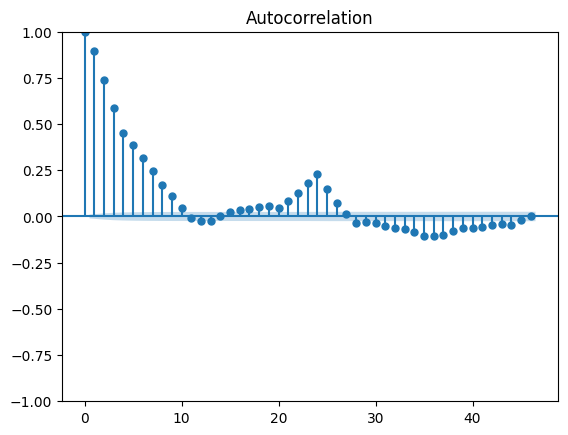

In [19]:
import statsmodels
statsmodels.graphics.tsaplots.plot_acf(train1["residual"]);

## GARCH 모델링

In [40]:
from arch import arch_model

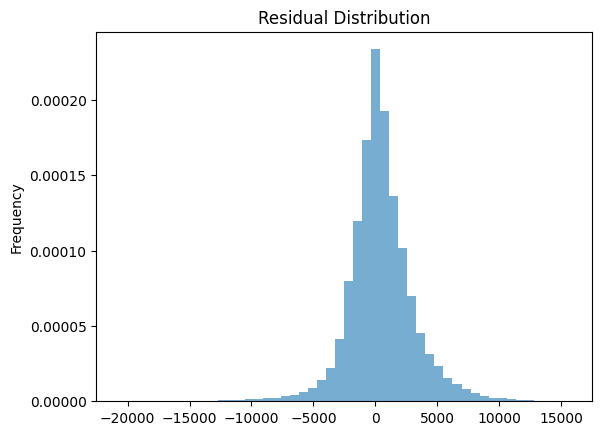

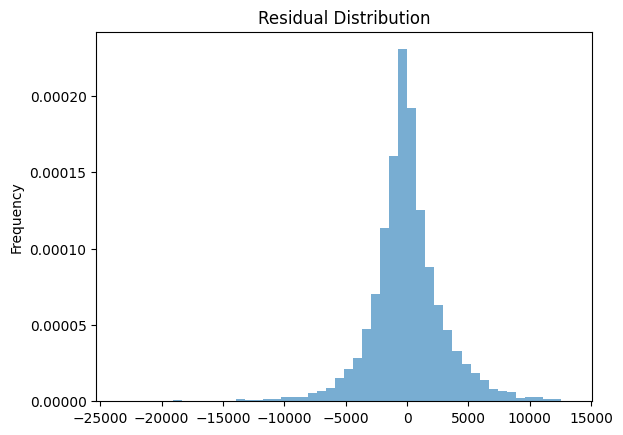

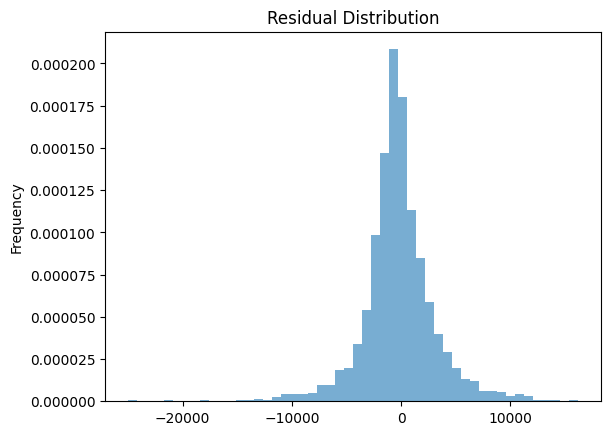

In [41]:
# 분포는 동일하게 좌측 skewness 한 분포임.

train1["residual"].plot(kind="hist", bins=50, density=True, alpha=0.6)
plt.title("Residual Distribution")
plt.show()

val1["residual"].plot(kind="hist", bins=50, density=True, alpha=0.6)
plt.title("Residual Distribution")
plt.show()

test1["residual"].plot(kind="hist", bins=50, density=True, alpha=0.6)
plt.title("Residual Distribution")
plt.show()


In [42]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from typing import Optional, List, Dict, Tuple, Callable
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.clip(np.abs(y_true), eps, None)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def _check_no_nan(name: str, arr: pd.Series | pd.DataFrame):
    if isinstance(arr, pd.Series):
        bad = ~np.isfinite(arr.to_numpy(dtype=float))
        if bad.any():
            idx = np.where(bad)[0][:5]
            raise ValueError(f"{name} 에 NaN/Inf가 있습니다. 예: idx {idx}")
    else:
        mat = arr.to_numpy(dtype=float)
        bad = ~np.isfinite(mat)
        if bad.any():
            # 어느 컬럼/행에 있는지 간단 표시
            where = np.argwhere(~np.isfinite(mat))[:5]
            raise ValueError(f"{name} 에 NaN/Inf가 있습니다. 예: 위치 {where.tolist()}")

def walk_forward_sarima(
    train_df: pd.DataFrame,
    val_df: Optional[pd.DataFrame],
    test_df: pd.DataFrame,
    target_col: str,
    exog_cols: Optional[List[str]] = None,          # 외생변수 컬럼명 리스트 (없으면 None)
    order: Tuple[int,int,int] = (4,0,0),            # SARIMA 비계절 차수
    seasonal_order: Tuple[int,int,int,int] = (1,0,0,24),  # (P,D,Q,s) s=24
    step: int = 1,                                  # 한 번에 예측할 스텝 수(보통 1)
    refit_each_step: bool = False,                  # True: 매스텝 재적합, False: 상태 append(빠름)
    maxiter: int = 200,
    disp: bool = False,
    metrics: Optional[Dict[str, Callable]] = None,
    verbose: bool = True,
    trend: Optional[str] = None,                    # 예: 'c', 't', 'ct', None
    enforce_stationarity: bool = False,
    enforce_invertibility: bool = False,
) -> Dict[str, object]:
    """
    SARIMA/SARIMAX 워크 포워드 예측 (test_df 구간을 step씩 예측/업데이트)
    - 데이터는 시간순 정렬 가정, 날짜 인덱스가 아니어도 됨.
    - exog 사용 시, train/val/test 전 구간에 동일 스키마/결측 없음이 요구됨.
    """

    if metrics is None:
        metrics = {"MAE": mean_absolute_error, "RMSE": rmse, "MAPE": mape}

    # 초기 학습 구간(train + val)
    if val_df is not None:
        init_df = pd.concat([train_df, val_df], axis=0)
    else:
        init_df = train_df.copy()

    # 시계열/외생변수 분리 및 dtype 통일
    y_init = init_df[target_col].astype(float)
    y_test = test_df[target_col].astype(float)

    X_init = init_df[exog_cols].astype(float) if exog_cols else None
    X_test = test_df[exog_cols].astype(float) if exog_cols else None

    # NaN/Inf 방지 체크
    _check_no_nan("y_init", y_init)
    _check_no_nan("y_test", y_test)
    if exog_cols:
        _check_no_nan("X_init", X_init)
        _check_no_nan("X_test", X_test)

    # 최소 길이: p + P*s
    p, d, q = order
    P, D, Q, s = seasonal_order
    min_needed = max(p + P * s, 1)
    if len(y_init) < min_needed:
        raise ValueError(f"초기 학습샘플이 부족합니다. 최소 {min_needed}개 필요 (현재 {len(y_init)}개).")

    # 최초 적합
    model = SARIMAX(
        endog=y_init,
        exog=X_init if exog_cols else None,
        order=order,
        seasonal_order=seasonal_order,
        trend=trend,
        enforce_stationarity=enforce_stationarity,
        enforce_invertibility=enforce_invertibility,
    )
    results = model.fit(maxiter=maxiter, disp=disp)

    preds, trues, per_step_metrics = [], [], []

    n = len(y_test)
    start = 0
    while start < n:
        end = min(start + step, n)

        # 예측용 exog 블록
        X_f = (X_test.iloc[start:end] if exog_cols else None)

        # 예측
        y_pred = results.forecast(steps=end - start, exog=X_f)
        y_true = y_test.iloc[start:end].to_numpy(dtype=float)

        preds.append(y_pred.to_numpy(dtype=float))
        trues.append(y_true)

        # 스텝별 점수
        step_scores = {k: fn(y_true, y_pred.to_numpy(dtype=float)) for k, fn in metrics.items()}
        per_step_metrics.append(step_scores)
        if verbose:
            print(f"[{start}:{end}] " + " | ".join(f"{k}={v:.4f}" for k, v in step_scores.items()))

        # 상태 업데이트: 실측을 append (인덱스 문제 회피 위해 numpy로 전달)
        if refit_each_step:
            # 재적합: 지금까지의 관측 모두 사용
            y_pool = pd.concat([y_init, y_test.iloc[:end]], axis=0)
            X_pool = (pd.concat([X_init, X_test.iloc[:end]], axis=0) if exog_cols else None)
            model = SARIMAX(
                endog=y_pool,
                exog=X_pool if exog_cols else None,
                order=order,
                seasonal_order=seasonal_order,
                trend=trend,
                enforce_stationarity=enforce_stationarity,
                enforce_invertibility=enforce_invertibility,
            )
            results = model.fit(maxiter=maxiter, disp=disp)
        else:
            X_a = (X_test.iloc[start:end].to_numpy(dtype=float) if exog_cols else None)
            results = results.append(
                endog=y_test.iloc[start:end].to_numpy(dtype=float),
                exog=X_a,
                refit=False
            )

        start = end

    # 결과 정리
    y_pred_full = np.concatenate(preds) if preds else np.array([], dtype=float)
    y_true_full = np.concatenate(trues) if trues else np.array([], dtype=float)
    overall = {k: fn(y_true_full, y_pred_full) for k, fn in metrics.items()} if len(y_true_full) else {}

    pred_series = pd.Series(index=test_df.index[:len(y_pred_full)], data=y_pred_full, name="sarima_pred")

    return {
        "pred_series": pred_series,
        "y_true": pd.Series(index=test_df.index[:len(y_true_full)], data=y_true_full, name="y_true"),
        "overall_metrics": overall,
        "per_step_metrics": pd.DataFrame(per_step_metrics),
    }


TypeError: unsupported operand type(s) for |: 'type' and 'type'

In [43]:
y_col = "residual"   # 실제 타깃 컬럼명으로 교체
# exog 없으면 None, 있으면 리스트로 컬럼명 지정
exog_cols = None  # 예: ["lag1", "lag24", "vol"] 처럼 숫자형 컬럼

res = walk_forward_sarima(
    train_df=train1,
    val_df=val1,
    test_df=test1,
    target_col=y_col,
    exog_cols=exog_cols,
    order=(4,0,0),
    seasonal_order=(1,0,0,24),
    step=4,
    refit_each_step=False,          # 먼저 False로 빠르게
    trend=None,                     # 필요시 'c'나 't' 시도
    enforce_stationarity=False,     # 필요시 True 시도
    enforce_invertibility=False,
    verbose=True
)

print("Overall:", res["overall_metrics"])


NameError: name 'walk_forward_sarima' is not defined

In [310]:
res["pred_series"]

{'pred_series': 43992   -1791.782435
 43993   -1647.370005
 43994   -1487.818517
 43995   -1082.957753
 43996    -328.637228
             ...     
 51139     -57.214681
 51140    -400.547101
 51141    -698.621541
 51142    -313.145701
 51143    -513.924971
 Name: sarima_pred, Length: 7152, dtype: float64,
 'y_true': 43992    -218.954023
 43993     172.932551
 43994      87.360760
 43995    -689.558636
 43996   -1436.302516
             ...     
 51139     -12.427596
 51140   -1062.640914
 51141   -1681.465880
 51142   -1520.655228
 51143   -2005.781027
 Name: y_true, Length: 7152, dtype: float64,
 'overall_metrics': {'MAE': 2523.187867430541,
  'RMSE': np.float64(3874.49631775676),
  'MAPE': 510.1009923723218},
 'per_step_metrics':              MAE         RMSE         MAPE
 0    2441.457329  3329.610226  6544.546419
 1    2755.884039  3722.638972   131.593829
 2    1662.674612  2483.324227   287.517878
 3    1437.123269  1695.639368    89.450221
 4    1508.386345  1771.677111   103.18

In [314]:
test1.reset_index(inplace=True)

In [317]:
test1["pred_sar"] = res["pred_series"].values

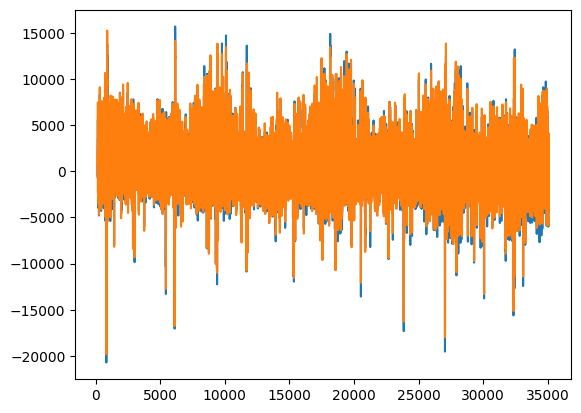

In [ ]:
plt.plot(train1["residual"])
plt.plot(fit.fittedvalues)

In [324]:
train1

,일시,hm,ta,power demand(MW),holiday_name,weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies,trend,detrend,seasonality,t,Fourier_Seasonality,Fourier_Residual,pred_inv,residual
168,2019-01-08 00:00:00,63.202734,-1.438430,69422.0,non-event,1,0,0,0,0,1,0,61020.611072,8401.388928,5584.217142,168,5584.217142,2817.171786,2295.357422,521.814364
169,2019-01-08 01:00:00,65.894092,-1.747963,66933.0,non-event,1,0,0,0,0,1,0,61020.708580,5912.291420,3220.866972,169,3220.866972,2691.424448,2821.905029,-130.480581
170,2019-01-08 02:00:00,64.376102,-2.080688,65477.0,non-event,1,0,0,0,0,1,0,61020.806088,4456.193912,1190.466257,170,1190.466257,3265.727654,3353.758301,-88.030646
171,2019-01-08 03:00:00,65.170723,-2.403730,64890.0,non-event,1,0,0,0,0,1,0,61020.903596,3869.096404,99.012855,171,99.012855,3770.083549,3669.046387,101.037162
172,2019-01-08 04:00:00,65.810582,-3.009894,65516.0,non-event,1,0,0,0,0,1,0,61021.001104,4494.998896,471.790802,172,471.790802,4023.208093,3678.876221,344.331872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2022-12-31 19:00:00,66.365476,0.227351,67392.0,non-event,0,1,0,0,0,1,0,64519.381328,2872.618672,7239.594639,35059,7239.594639,-4366.975967,-3934.339600,-432.636368
35060,2022-12-31 20:00:00,70.338988,-0.551577,66648.0,non-event,0,1,0,0,0,1,0,64519.484427,2128.515573,6452.634291,35060,6452.634291,-4324.118718,-3045.215088,-1278.903630
35061,2022-12-31 21:00:00,73.889286,-1.225030,65914.0,non-event,0,1,0,0,0,1,0,64519.587525,1394.412475,5407.459226,35061,5407.459226,-4013.046751,-2208.895020,-1804.151732
35062,2022-12-31 22:00:00,76.481250,-1.560863,65739.0,non-event,0,1,0,0,0,1,0,64519.690624,1219.309376,4178.115554,35062,4178.115554,-2958.806178,-1489.143921,-1469.662257


In [31]:
# 
train1["hybrid"] = train1["trend"] +train1["Fourier_Seasonality"] + train1["pred_inv"]
val1["hybrid"] =  val1["trend"] +val1["Fourier_Seasonality"] + val1["pred_inv"]
test1["hybrid"] =  test1["trend"] +test1["Fourier_Seasonality"] + test1["pred_inv"]

In [321]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
real = test1["power demand(MW)"]
# 일반 평가지표 
print(f"MSE : {np.round(mean_squared_error(real, y_hat),5)}")
print(f"r2_score : {np.round(r2_score(real, y_hat),5)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(real, y_hat),5)}")
print(f"RMSE : {np.round(np.sqrt(mean_squared_error(real, y_hat)),5)}")

MSE : 15011721.71631
r2_score : 0.86118
MAPE : 0.04006
RMSE : 3874.49632


## Tilting 생성ㅅ

In [32]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple
# PyMC + LKJ
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import norm


# =========================
# 0) 기본 설정 (추석/설날만)
# =========================


CHUSEOK_CORE = {"Chuseok"}
CHUSEOK_ALIASES = {
    "The day preceding Chuseok",
    "The second day of Chuseok",
    "Alternative holiday for Chuseok",
}
SEOLLAL_CORE = {"Korean New Year"}
SEOLLAL_ALIASES = {
    "The day preceding Korean New Year",
    "The second day of Korean New Year",
    "Alternative holiday for Korean New Year",
}

CHUSEOK_LABELS = CHUSEOK_CORE | CHUSEOK_ALIASES
SEOLLAL_LABELS = SEOLLAL_CORE | SEOLLAL_ALIASES


@dataclass
class HQTResult:
    # posterior draws
    draws_beta: np.ndarray         # [S, I, 3]  (이벤트 i별 β 샘플)
    draws_mu: np.ndarray           # [S, H, 3]  (유형별 μ 샘플; H=2: Chuseok/Seollal)
    draws_sigma_r: np.ndarray      # [S]
    # indices / metadata
    event_ids: List[str]           # 학습에 들어간 이벤트 ID 순서 (원본 정렬)
    event_type: List[str]          # 각 이벤트의 유형 ("Chuseok"|"Seollal")
    type_names: List[str]          # ["Chuseok","Seollal"] 고정
    tau_map: Dict[Tuple[str, pd.Timestamp], int]   # (event_id, ts) -> τ (정수, tau_unit 단위)
    event_id_of_date: Dict[pd.Timestamp, str]      # ts -> event_id (전체 기간)
    type_of_date: Dict[pd.Timestamp, str]          # ts -> "Chuseok"/"Seollal"
    # τ 메타
    tau_unit_hours: float          # τ의 기본 단위(시간) 예: 1.0 (1시간)
    tau_scale_hours: float         # 모형에서 τ를 나눌 스케일(시간) 예: 24.0 (하루)


def _per_draw_type_covs(hqt: HQTResult) -> List[np.ndarray]:
    """
    각 타입 h에 대해, 사후 draw마다 (3x3) 공분산 행렬을 추정해 반환.
    반환: covs[h]의 shape = (S, 3, 3)
    방법:
      - draw s마다, 해당 타입 h의 이벤트들의 β_s (n_h x 3)를 모아 표본공분산을 계산.
      - n_h < 2이면 (불안정) → 모든 draw 묶음으로 (S*n_h x 3) 전역 공분산을 사용.
    """
    S, I, _ = hqt.draws_beta.shape
    type_to_idx = {t: i for i, t in enumerate(hqt.type_names)}
    # 타입별 이벤트 인덱스
    idxs_by_type = [[] for _ in hqt.type_names]
    for i, t in enumerate(hqt.event_type):
        idxs_by_type[type_to_idx[t]].append(i)

    covs_by_type = []
    for h, idxs in enumerate(idxs_by_type):
        idxs = np.array(idxs, dtype=int)
        if len(idxs) >= 2:
            # draw별 표본공분산
            covs = np.zeros((S, 3, 3), dtype=float)
            for s in range(S):
                B = hqt.draws_beta[s, idxs, :]  # (n_h, 3)
                # rowvar=False → 열을 변수로, ddof=1
                C = np.cov(B, rowvar=False) if B.shape[0] > 1 else np.eye(3)
                # 수치 안정화용 리지
                covs[s] = C + 1e-6 * np.eye(3)
        else:
            # 이벤트가 1개 이하: 모든 draw/이벤트를 합쳐 전역 공분산 근사
            B_all = hqt.draws_beta[:, idxs, :].reshape(-1, 3) if len(idxs) > 0 else hqt.draws_beta.reshape(-1, 3)
            C = np.cov(B_all, rowvar=False) if B_all.shape[0] > 1 else np.eye(3)
            C = C + 1e-6 * np.eye(3)
            covs = np.repeat(C[None, :, :], S, axis=0)
        covs_by_type.append(covs)
    return covs_by_type  # list length H, each (S,3,3)


def _sample_new_event_beta(
    rng: np.random.Generator,
    mu_draws_h: np.ndarray,     # (S, 3)  : 해당 타입 h의 μ 사후 드로우
    cov_draws_h: np.ndarray,    # (S, 3,3): 해당 타입 h의 Σ 사후(근사) 드로우
) -> np.ndarray:
    """
    새 이벤트 β_new의 사후예측 드로우를 생성.
    각 draw s에 대해 β_new,s ~ N( μ_{h,s}, Σ_{h,s} )
    반환: (S, 3)
    """
    S = mu_draws_h.shape[0]
    betas = np.zeros((S, 3), dtype=float)
    for s in range(S):
        betas[s] = rng.multivariate_normal(mean=mu_draws_h[s], cov=cov_draws_h[s])
    return betas


# ==================================
# 1) 윈도우/τ 생성 (라벨 기반: radius 불필요)
# ==================================

def _date_index(df: pd.DataFrame, date_col: Optional[str]) -> pd.Series:
    if date_col is not None:
        idx = pd.to_datetime(df[date_col])
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("date_col을 지정하지 않았고, 인덱스가 DatetimeIndex가 아닙니다.")
        idx = pd.to_datetime(df.index)
    return idx


def build_holiday_windows_and_tau_by_label(
    df_all: pd.DataFrame,
    holiday_name_col: str = "holiday_name",
    date_col: Optional[str] = None,
    center_hour: int = 0,          # 중심 시각(자정 + center_hour)
    tau_unit: str = "1h",          # τ 단위 (예: '1h','30T','15T')
    pre_pad_days: int = 0,         # 시작일 이전 추가 포함할 일수
    post_pad_days: int = 0,        # 종료일 이후 추가 포함할 일수
) -> Tuple[Dict[str, List[pd.Timestamp]],
           Dict[Tuple[str, pd.Timestamp], int],
           Dict[pd.Timestamp, str],
           Dict[pd.Timestamp, str],
           float]:
    """
    라벨만으로 추석/설날 '사건(event)'을 연도별로 만들고
    각 타임스탬프별 τ(중심시각 대비 'tau_unit' 단위의 정수 시차)와 타입을 매핑.
    - event_id: "YYYY_Chuseok" 또는 "YYYY_Seollal"
    - 중심시각 t0: 코어일(Chuseok/Korean New Year) '날짜'의 자정 + center_hour
    - 윈도우: 해당 연도에서 holiday_name이 (core ∪ aliases)에 속하는 모든 타임스탬프
      + 선택적으로 (pre_pad_days, post_pad_days) 만큼 앞뒤 '일' 단위 패딩을 포함
        (연도 경계 넘어가도 포함함)
    """
    idx = _date_index(df_all, date_col)
    names = df_all[holiday_name_col].astype(str).values
    df_tmp = pd.DataFrame({"date": idx, "holiday": names}).set_index("date")

    tau_unit_td = pd.to_timedelta(tau_unit)
    tau_unit_hours = tau_unit_td / pd.Timedelta(hours=1)

    windows: Dict[str, List[pd.Timestamp]] = {}
    tau_map: Dict[Tuple[str, pd.Timestamp], int] = {}
    event_id_of_date: Dict[pd.Timestamp, str] = {}
    type_of_date: Dict[pd.Timestamp, str] = {}

    # 중심(코어 라벨)만 스캔하여 연도별 이벤트 생성
    for d, name in zip(idx, names):
        if name in CHUSEOK_CORE:
            tname, labels = "Chuseok", CHUSEOK_LABELS
        elif name in SEOLLAL_CORE:
            tname, labels = "Seollal", SEOLLAL_LABELS
        else:
            continue

        y = int(pd.Timestamp(d).year)
        eid = f"{y}_{tname}"
        if eid in windows:
            continue

        # 중심시각 t0: 코어 '날짜'의 자정 + center_hour (타임존 유지)
        d0 = pd.Timestamp(d).normalize() + pd.Timedelta(hours=center_hour)

        # 같은 연도에 해당 라벨 집합에 속하는 모든 타임스탬프(기존 동작)
        mask_year = (df_tmp.index.year == y)
        mask_lab = df_tmp["holiday"].isin(labels)
        stamps = sorted(df_tmp.index[mask_year & mask_lab].unique().tolist())
        if not stamps:
            stamps = [d0]  # 안전장치

        # --- 앞/뒤 '일' 단위 패딩 추가 (라벨 무관, 연도 경계 넘어도 포함) ---
        if pre_pad_days > 0 or post_pad_days > 0:
            # 이벤트 라벨이 붙은 구간의 '날짜' 범위를 잡고 그 앞/뒤 날짜의 모든 타임스탬프를 포함
            date_set = {pd.Timestamp(s).normalize() for s in stamps}
            min_date = min(date_set)
            max_date = max(date_set)

            # 패딩 구간(날짜 기준, 양쪽 닫힌 구간)
            start_pad_date = min_date - pd.Timedelta(days=pre_pad_days)
            end_pad_date   = max_date + pd.Timedelta(days=post_pad_days)

            # df 전체에서 해당 날짜 구간에 속하는 모든 타임스탬프 선택
            base_dates = df_tmp.index.normalize()
            mask_pad = (base_dates >= start_pad_date) & (base_dates <= end_pad_date)

            # 원래 스탬프 + 패딩 스탬프 합집합
            pad_stamps = df_tmp.index[mask_pad].unique().tolist()
            stamps = sorted(set(stamps).union(pad_stamps))

        windows[eid] = stamps

        # τ(정수) / 매핑 (tau_unit 기준 반올림)
        for dd in stamps:
            dd = pd.Timestamp(dd)
            delta = dd - d0
            tau_float = delta / tau_unit_td
            tau_int = int(np.rint(float(tau_float)))
            tau_map[(eid, dd)] = tau_int
            event_id_of_date[dd] = eid
            type_of_date[dd] = tname

    return windows, tau_map, event_id_of_date, type_of_date, float(tau_unit_hours)



# ==================================
# 2) 표준화 잔차 / σ (비명절일에서)
# ==================================

def compute_sigma_and_residuals(
    df: pd.DataFrame,
    y_col: str,
    pred_col: str,
    holiday_name_col: str = "holiday_name",
) -> Tuple[float, pd.Series]:
    """
    σ: holiday_name == 'non-event' 에서의 잔차 표준편차
    z_t 계산은 나중 PyMC 입력에서 사용
    """
    y = pd.to_numeric(df[y_col])
    yhat = pd.to_numeric(df[pred_col])
    resid = y - yhat
    mask_non = (df[holiday_name_col].astype(str) == "non-event")
    sigma = float(resid[mask_non].std(ddof=1))
    if not np.isfinite(sigma) or sigma <= 0:
        raise ValueError("비명절(non-event) 표본에서 σ를 계산할 수 없습니다. 입력을 확인하세요.")
    return sigma, resid


# ==================================
# 3) PyMC(LKJ) 계층 이차 틸트 적합 (non-centered)
# ==================================

def fit_hqt_pymc_lkj(
    df_train: pd.DataFrame,
    sigma_resid: float,
    resid_train: pd.Series,
    tau_map: Dict[Tuple[str, pd.Timestamp], int],
    event_id_of_date_all: Dict[pd.Timestamp, str],
    type_of_date_all: Dict[pd.Timestamp, str],
    tau_scale_hours: float = 24.0,       # 모형 안정화를 위한 스케일(24h=1일)
    tau_unit_hours: float = 1.0,         # τ의 기본 단위(시간)
    chains: int = 4,
    draws: int = 1000,
    tune: int = 1000,
    target_accept: float = 0.95,
    random_seed: int = 2025,
    date_col: Optional[str] = None,
    sampler: str = "nuts",  # "nuts" | "numpyro" | "advi"
) -> HQTResult:
    """
    z_t ~ N(β_i0 + β_i1 τs + β_i2 τs^2, σ_r^2)
    τs = (τ * tau_unit_hours) / tau_scale_hours
    β_i = μ_type + L_type ε_i (ε_i ~ N(0, I))   # non-centered
    L_type 는 LKJCholeskyCov로부터 얻은 (3x3) 하삼각
    """

    idx = _date_index(df_train, date_col)
    dates = [d for d in idx if d in event_id_of_date_all]
    if len(dates) == 0:
        raise ValueError("학습 세트에 추석/설날 윈도우 날짜가 없습니다.")

    # 이벤트/유형 인덱스 (훈련에 등장한 이벤트만)
    ev_ids_sorted = sorted({event_id_of_date_all[d] for d in dates}, key=str)
    I = len(ev_ids_sorted)
    eid_to_int = {e: i for i, e in enumerate(ev_ids_sorted)}

    types_sorted = ["Chuseok", "Seollal"]
    H = len(types_sorted)
    type_to_int = {t: i for i, t in enumerate(types_sorted)}
    h_of_event = np.array([type_to_int[e.split("_")[1]] for e in ev_ids_sorted], dtype=int)

    # 관측 벡터
    z_vec = np.array([resid_train.loc[d] / sigma_resid for d in dates], dtype=float)
    tau_vec = np.array([float(tau_map[(event_id_of_date_all[d], d)]) for d in dates], dtype=float)
    tau_scaled = (tau_vec * float(tau_unit_hours)) / float(tau_scale_hours)

    e_idx_orig = np.array([eid_to_int[event_id_of_date_all[d]] for d in dates], dtype=int)

    # 타입별 이벤트 인덱스와 concat 순서 매핑
    idx_by_type = [np.where(h_of_event == h)[0] for h in range(H)]
    concat_order = np.concatenate([ix for ix in idx_by_type if len(ix) > 0])  # 길이 I
    pos_of_event = np.empty(I, dtype=int)
    for pos, orig_idx in enumerate(concat_order):
        pos_of_event[orig_idx] = pos
    e_idx = pos_of_event[e_idx_orig]  # 관측에서 사용할 concat 기준 인덱스

    with pm.Model() as m:
        # 유형별 평균 (μ_h ∈ R^3)
        mu = pm.Normal("mu", mu=0.0, sigma=10.0, shape=(H, 3))

        # 유형별 공분산: LKJCholeskyCov (packed → expand)
        L_list = []
        for h in range(H):
            sd = pm.HalfNormal.dist(1.0, shape=3)
            packed = pm.LKJCholeskyCov(
                f"chol_packed_{h}", n=3, eta=2.0, sd_dist=sd,
                compute_corr=False, store_in_trace=False
            )
            L_h = pm.expand_packed_triangular(3, packed, lower=True)  # (3,3)
            L_list.append(L_h)

        # non-centered: β_type 블록 생성
        beta_blocks = []
        for h in range(H):
            idx_h = idx_by_type[h]
            n_h = len(idx_h)
            if n_h > 0:
                eps = pm.Normal(f"eps_type{h}", mu=0.0, sigma=1.0, shape=(n_h, 3))
                beta_h = pm.Deterministic(
                    f"beta_type{h}", mu[h] + eps @ L_list[h].T  # (n_h,3)
                )
                beta_blocks.append(beta_h)

        # concat 기준의 β (I,3)
        beta_concat = beta_blocks[0] if len(beta_blocks) == 1 else pt.concatenate(beta_blocks, axis=0)

        sigma_r = pm.HalfNormal("sigma_r", 1.0)

        # 우도 (τ는 스케일링된 tau_scaled 사용)
        mu_z = beta_concat[e_idx, 0] + beta_concat[e_idx, 1] * tau_scaled + beta_concat[e_idx, 2] * pt.sqr(tau_scaled)
        pm.Normal("z_like", mu=mu_z, sigma=sigma_r, observed=z_vec)

        # 샘플링
        if sampler == "advi":
            approx = pm.fit(50_000, random_seed=random_seed)
            idata = approx.sample(draws=draws, random_seed=random_seed)

        elif sampler == "numpyro":
            try:
                import pymc.sampling.jax as pmjax
            except Exception as e:
                raise RuntimeError(
                    "sampler='numpyro'를 요청했지만 'pymc.sampling.jax'를 불러오지 못했습니다. "
                    "PyMC 버전 및 JAX/NumPyro 설치를 확인하세요."
                ) from e

            _kwargs = dict(
                chains=chains, draws=draws, tune=tune,
                target_accept=target_accept, random_seed=random_seed,
                progressbar=False
            )
            try:
                idata = pmjax.sample_numpyro_nuts(
                    **_kwargs,
                    chain_method="vectorized",
                    postprocessing_backend="cpu",
                    idata_kwargs={"log_likelihood": False},
                )
            except TypeError:
                idata = pmjax.sample_numpyro_nuts(**_kwargs)

        else:  # "nuts"
            idata = pm.sample(
                chains=chains, draws=draws, tune=tune,
                target_accept=target_accept, random_seed=random_seed, progressbar=False
            )

    # posterior 정리
    arrays = []
    for h in range(H):
        key = f"beta_type{h}"
        if key in idata.posterior:
            arr = idata.posterior[key].values  # (chain, draw, n_h, 3)
            arr = np.moveaxis(arr, 0, 1).reshape(-1, arr.shape[2], 3)  # (S, n_h, 3)
            arrays.append(arr)
    draws_beta_concat = arrays[0] if len(arrays) == 1 else np.concatenate(arrays, axis=1)  # (S, I, 3)
    draws_beta = draws_beta_concat[:, pos_of_event, :]  # concat → 원래 이벤트 순서

    mu_draws = idata.posterior["mu"].values  # (chain, draw, H, 3)
    mu_draws = np.moveaxis(mu_draws, 0, 1).reshape(-1, H, 3)

    sigma_r_draws = idata.posterior["sigma_r"].values  # (chain, draw)
    sigma_r_draws = np.moveaxis(sigma_r_draws, 0, 1).reshape(-1)

    return HQTResult(
        draws_beta=draws_beta,
        draws_mu=mu_draws,
        draws_sigma_r=sigma_r_draws,
        event_ids=ev_ids_sorted,
        event_type=[types_sorted[h] for h in h_of_event],
        type_names=types_sorted,
        tau_map={k: int(v) for k, v in tau_map.items()},
        event_id_of_date=event_id_of_date_all.copy(),
        type_of_date=type_of_date_all.copy(),
        tau_unit_hours=float(tau_unit_hours),
        tau_scale_hours=float(tau_scale_hours),
    )


# ==================================
# 4) 틸트 계산/적용 (학습·검증·테스트)
# ==================================

def tilt_from_posterior_LKJ(
    hqt: HQTResult,
    sigma_resid: float,
    dates: Iterable[pd.Timestamp],
    tilt_mode: str = "hybrid",   # "hybrid" | "event" | "type"
    ci: float = 0.95,
    rng_seed: Optional[int] = 2025,   # 사후예측 샘플링 재현성
) -> Tuple[pd.Series, float, pd.Series]:
    """
    보강된 event(+가변 구간폭):
      - 학습에서 본 이벤트: draw별 β_i로 z_draws 계산 → 평균/표준편차 사용
      - 학습에 없는 새 이벤트: 각 draw마다 β_new,s ~ N( μ_{h,s}, Σ_{h,s} ) 샘플 → z_draws
      - type/hybrid도 draw 기반으로 z_draws를 만들고 평균/표준편차 사용
    반환:
      e_tilt: σ * E[z_t | data]
      half_width_const: 논문식 상수폭 (비교용)
      half_width_t: 날짜별 가변 폭 (draw 분산 반영)
    """
    dates = list(pd.to_datetime(pd.Index(dates)))

    # --- 사후 요약들 ---
    B_draws = hqt.draws_beta                 # (S, I, 3)
    MU_draws = hqt.draws_mu                  # (S, H, 3)
    S = B_draws.shape[0]

    # --- 상수폭 계산에 필요한 값(논문식) ---
    sigma_r_sq_mean = float((hqt.draws_sigma_r ** 2).mean())
    zcrit = norm.ppf(0.5 + ci / 2.0)
    half_width_const = float(zcrit * sigma_resid * np.sqrt(1.0 + sigma_r_sq_mean))

    # --- 맵/인덱스 ---
    eid_to_pos = {e: i for i, e in enumerate(hqt.event_ids)}
    type_to_pos = {t: i for i, t in enumerate(hqt.type_names)}

    # --- 보강된 event 모드용: 타입별 per-draw 공분산 근사 ---
    use_pp_for_unseen = (tilt_mode == "event")
    covs_by_type = _per_draw_type_covs(hqt) if use_pp_for_unseen else None
    rng = np.random.default_rng(rng_seed)

    # --- 날짜별 z_{draws} 만들고 평균/표준편차 계산 ---
    zhat_vals: List[float] = []
    hw_vals: List[float] = []

    for d in dates:
        eid = hqt.event_id_of_date.get(d)
        if eid is None:
            # 비명절 → z_hat = 0, 폭도 0 (원하면 half_width_const로 바꿔도 됨)
            zhat_vals.append(0.0)
            hw_vals.append(0.0)
            continue

        tau = hqt.tau_map.get((eid, d), 0)  # 정수 τ
        tau_s = (float(tau) * hqt.tau_unit_hours) / hqt.tau_scale_hours

        # 모드별 draw 기반 z_draws
        if tilt_mode == "type":
            h = type_to_pos[hqt.type_of_date[d]]
            MU_h = MU_draws[:, h, :]                            # (S,3)
            z_draws = MU_h[:, 0] + MU_h[:, 1]*tau_s + MU_h[:, 2]*(tau_s**2)

        elif tilt_mode == "event":
            if eid in eid_to_pos:
                i = eid_to_pos[eid]
                B_i = B_draws[:, i, :]                          # (S,3)
                z_draws = B_i[:, 0] + B_i[:, 1]*tau_s + B_i[:, 2]*(tau_s**2)
            else:
                # 새 이벤트: 사후예측으로 β_new,s ~ N( μ_{h,s}, Σ_{h,s} )
                h = type_to_pos[hqt.type_of_date[d]]
                mu_draws_h  = MU_draws[:, h, :]                 # (S,3)
                cov_draws_h = covs_by_type[h]                   # (S,3,3)
                betas_new   = _sample_new_event_beta(rng, mu_draws_h, cov_draws_h)  # (S,3)
                z_draws     = betas_new[:, 0] + betas_new[:, 1]*tau_s + betas_new[:, 2]*(tau_s**2)

        else:  # hybrid
            if eid in eid_to_pos:
                i = eid_to_pos[eid]
                B_i = B_draws[:, i, :]
                z_draws = B_i[:, 0] + B_i[:, 1]*tau_s + B_i[:, 2]*(tau_s**2)
            else:
                h = type_to_pos[hqt.type_of_date[d]]
                MU_h = MU_draws[:, h, :]
                z_draws = MU_h[:, 0] + MU_h[:, 1]*tau_s + MU_h[:, 2]*(tau_s**2)

        z_mean = float(np.mean(z_draws))
        std_z  = float(np.std(z_draws, ddof=1))
        zhat_vals.append(z_mean)

        # 가변폭: Var(y_t|data) ≈ σ^2 (1 + E[σ_r^2]) + σ^2 Var(z_t|data)
        half_width_t = float(zcrit * np.sqrt((sigma_resid**2) * (1.0 + sigma_r_sq_mean + std_z**2)))
        hw_vals.append(half_width_t)

    zhat = pd.Series(zhat_vals, index=pd.Index(dates, name="date"), name="z_hat")
    e_tilt = sigma_resid * zhat
    half_width_t = pd.Series(hw_vals, index=zhat.index, name="half_width_t")
    return e_tilt, half_width_const, half_width_t


def apply_tilt(baseline_pred: pd.Series, e_tilt: pd.Series) -> pd.Series:
    return (baseline_pred + e_tilt.reindex(baseline_pred.index).fillna(0.0)).rename("tilted_pred")


# ==================================
# 5) 지표
# ==================================

def mae(y, yhat): return float(np.mean(np.abs(np.asarray(y) - np.asarray(yhat))))
def rmse(y, yhat): return float(np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat)) ** 2)))

def trough_bias_per_event(
    y: pd.Series, pred: pd.Series, windows: Dict[str, List[pd.Timestamp]]
) -> float:
    biases = []
    for eid, days in windows.items():
        ds = [d for d in days if d in y.index]
        if not ds:
            continue
        dmin = y.loc[ds].idxmin()
        biases.append(float(pred.loc[dmin] - y.loc[dmin]))
    return float(np.mean(biases)) if biases else np.nan


def interval_stats(y: pd.Series, pred: pd.Series, half_width: float):
    lower = pred - half_width
    upper = pred + half_width
    picp = float(np.mean((y >= lower) & (y <= upper)) * 100.0)
    aiw = float(np.mean(upper - lower))
    return picp, aiw


# ==================================
# 6) End-to-End 헬퍼
# ==================================

def run_hqt_pipeline_LKJ(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    y_col: str,
    pred_col: str,
    holiday_name_col: str = "holiday_name",
    date_col: Optional[str] = None,
    tilt_mode: str = "hybrid",  # "hybrid" | "event" | "type"
    # 샘플링 옵션
    chains: int = 4,
    draws: int = 1000,
    tune: int = 1000,
    target_accept: float = 0.95,
    sampler: str = "nuts",  # "nuts" | "numpyro" | "advi"
    random_seed: int = 2025,
    # τ 옵션
    center_hour: int = 0,
    tau_unit: str = "1h",
    tau_scale_hours: float = 24.0,
    pre_pad_days: int = 1,       # ← 추가
    post_pad_days: int = 1,      # ← 추가
):
    """
    1) 윈도우/τ 생성(전체 데이터로; 라벨 기반, 시간단위)
    2) σ, 잔차 계산(훈련에서 비명절)
    3) PyMC(LKJ, non-centered) HQT 적합(훈련)
    4) 틸트 산출/적용(훈련·검증·테스트)
    5) 평가 지표 반환
    """
    # 1) 윈도우/τ (라벨 기반, 시간단위)
    all_df = pd.concat(
        [train_df[[holiday_name_col]], val_df[[holiday_name_col]], test_df[[holiday_name_col]]]
    )
    windows, tau_map, eid_of_date, type_of_date, tau_unit_hours = build_holiday_windows_and_tau_by_label(
        all_df, holiday_name_col=holiday_name_col, date_col=date_col,
        center_hour=center_hour, tau_unit=tau_unit,     pre_pad_days=pre_pad_days,
        post_pad_days=post_pad_days,
)

    # 2) σ/잔차(훈련)
    sigma_resid, resid_train = compute_sigma_and_residuals(train_df, y_col, pred_col, holiday_name_col)

    # 3) 적합
    hqt = fit_hqt_pymc_lkj(
        df_train=train_df,
        sigma_resid=sigma_resid,
        resid_train=resid_train,
        tau_map=tau_map,
        event_id_of_date_all=eid_of_date,
        type_of_date_all=type_of_date,
        tau_scale_hours=tau_scale_hours,
        tau_unit_hours=tau_unit_hours,
        chains=chains,
        draws=draws,
        tune=tune,
        target_accept=target_accept,
        sampler=sampler,
        random_seed=random_seed,
        date_col=date_col,
    )

    # 4) 각 분할별 틸트/적용/지표
    def _one_split(df):
        idx = _date_index(df, date_col)
        y = pd.to_numeric(df[y_col])
        base = pd.to_numeric(df[pred_col]).rename("baseline_pred")

        # e_tilt, 상수폭, 가변폭 모두 받기
        e_tilt, half_width_const, half_width_t = tilt_from_posterior_LKJ(
            hqt, sigma_resid, idx, tilt_mode=tilt_mode
        )
        tilted = apply_tilt(base, e_tilt)

        # 명절 마스크
        holiday_ts = [d for d in idx if d in eid_of_date]
        mask_h = pd.Index(idx).isin(holiday_ts)

        # --- 신뢰구간 (가변폭 사용) ---
        lower_t = tilted - half_width_t.reindex(idx).fillna(0.0)
        upper_t = tilted + half_width_t.reindex(idx).fillna(0.0)

        # 지표 (가변폭 기준)
        if np.any(mask_h):
            picp = float(np.mean((y[mask_h] >= lower_t[mask_h]) & (y[mask_h] <= upper_t[mask_h])) * 100.0)
            aiw  = float(np.mean((upper_t - lower_t)[mask_h]))
        else:
            picp, aiw = (np.nan, np.nan)

        metrics = {
            "MAE_all": mae(y, tilted),
            "RMSE_all": rmse(y, tilted),
            "MAE_holiday": mae(y[mask_h], tilted[mask_h]) if np.any(mask_h) else np.nan,
            "RMSE_holiday": rmse(y[mask_h], tilted[mask_h]) if np.any(mask_h) else np.nan,
            "PICP_95": picp,
            "AIW": aiw,
            "half_width_const": half_width_const,  # 비교용으로 그대로 남겨둠
        }

        out = pd.DataFrame({
            "y": y,
            "baseline_pred": base,
            "e_tilt": e_tilt.reindex(idx).fillna(0.0),
            "tilted_pred": tilted,
            "half_width_t": half_width_t.reindex(idx).fillna(0.0),
            "lower_t": lower_t,
            "upper_t": upper_t,
        }, index=idx)
        return out, metrics


    train_out, train_metrics = _one_split(train_df)
    val_out, val_metrics = _one_split(val_df)
    test_out, test_metrics = _one_split(test_df)

    return {
        "hqt": hqt,
        "sigma_resid": sigma_resid,
        "windows": windows,
        "train": {"preds": train_out, "metrics": train_metrics},
        "val": {"preds": val_out, "metrics": val_metrics},
        "test": {"preds": test_out, "metrics": test_metrics},
    }




In [33]:
# 최초 한번만 처리

train1.set_index("일시", inplace=True)
val1.set_index("일시", inplace=True)
test1.set_index("일시", inplace=True)

KeyError: "None of ['일시'] are in the columns"

In [34]:
train1

,hm,ta,power demand(MW),holiday_name,weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies,trend,detrend,seasonality,t,Fourier_Seasonality,Fourier_Residual,pred_inv,residual,hybrid
일시,,,,,,,,,,,,,,,,,,,,
2019-01-08 00:00:00,63.202734,-1.438430,69422.0,non-event,1,0,0,0,0,1,0,61020.611072,8401.388928,5584.217142,168,5584.217142,2817.171786,2295.432861,521.738925,68900.261075
2019-01-08 01:00:00,65.894092,-1.747963,66933.0,non-event,1,0,0,0,0,1,0,61020.708580,5912.291420,3220.866972,169,3220.866972,2691.424448,2821.884521,-130.460074,67063.460074
2019-01-08 02:00:00,64.376102,-2.080688,65477.0,non-event,1,0,0,0,0,1,0,61020.806088,4456.193912,1190.466257,170,1190.466257,3265.727654,3353.798340,-88.070685,65565.070685
2019-01-08 03:00:00,65.170723,-2.403730,64890.0,non-event,1,0,0,0,0,1,0,61020.903596,3869.096404,99.012855,171,99.012855,3770.083549,3669.132324,100.951225,64789.048775
2019-01-08 04:00:00,65.810582,-3.009894,65516.0,non-event,1,0,0,0,0,1,0,61021.001104,4494.998896,471.790802,172,471.790802,4023.208093,3679.070312,344.137781,65171.862219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,66.365476,0.227351,67392.0,non-event,0,1,0,0,0,1,0,64519.381328,2872.618672,7239.594639,35059,7239.594639,-4366.975967,-3934.352051,-432.623916,67824.623916
2022-12-31 20:00:00,70.338988,-0.551577,66648.0,non-event,0,1,0,0,0,1,0,64519.484427,2128.515573,6452.634291,35060,6452.634291,-4324.118718,-3045.434570,-1278.684148,67926.684148
2022-12-31 21:00:00,73.889286,-1.225030,65914.0,non-event,0,1,0,0,0,1,0,64519.587526,1394.412474,5407.459226,35061,5407.459226,-4013.046751,-2209.302979,-1803.743773,67717.743773


In [35]:
results_event = run_hqt_pipeline_LKJ(
    train_df=train1,
    val_df=val1,
    test_df=test1,
    
    y_col="power demand(MW)",
    
    pred_col="hybrid",
    
    holiday_name_col="holiday_name",
    
    date_col=None,             
    sampler="numpyro",                    # "nuts"|"numpyro"|"advi"
    target_accept=0.99,                # 안정화 권장
    chains=4, draws=3000, tune=2000,
    tilt_mode="hybrid",   # "event" | "type" | "hybrid"
    pre_pad_days=1,                # ← 시작 하루 전 포함
    post_pad_days=1,               # ← 종료 하루 후 포함
)

/Users/ijongseung/Demadn-Quadratic-Tilting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
results_event

hybrid_tilt = results_event["test"]["preds"]
hybrid_tilt_1 = hybrid_tilt[hybrid_tilt["e_tilt"]!=0]

In [42]:
hybrid_tilt_1

,y,baseline_pred,e_tilt,tilted_pred,half_width_t,lower_t,upper_t
일시,,,,,,,
2024-02-08 00:00:00,67039.0,67463.018576,555.475388,68018.493964,13077.195582,54941.298382,81095.689546
2024-02-08 01:00:00,64374.0,64986.292191,322.130581,65308.422772,12967.988143,52340.434629,78276.410915
2024-02-08 02:00:00,62791.0,63585.880891,94.008824,63679.889715,12865.047469,50814.842246,76544.937184
2024-02-08 03:00:00,62152.0,63209.829620,-128.889885,63080.939735,12768.217923,50312.721812,75849.157658
2024-02-08 04:00:00,62560.0,63983.033639,-346.565544,63636.468095,12677.336598,50959.131497,76313.804693
...,...,...,...,...,...,...,...
2024-09-19 19:00:00,87465.0,71215.986724,6186.969911,77402.956635,14433.099502,62969.857133,91836.056136
2024-09-19 20:00:00,83239.0,69096.197259,6492.939291,75589.136550,14579.412976,61009.723573,90168.549526
2024-09-19 21:00:00,78470.0,66922.676312,6802.974316,73725.650628,14730.699552,58994.951076,88456.350181


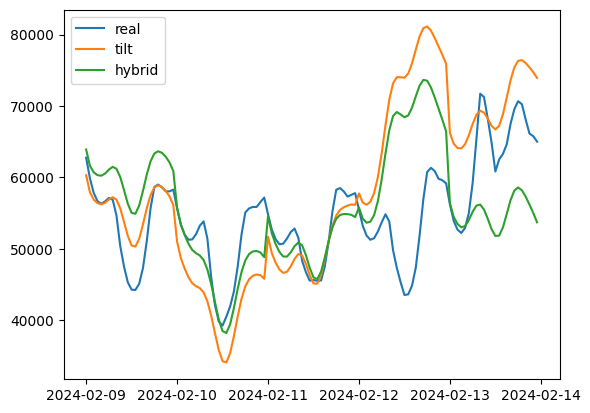

In [50]:
# y	baseline_pred	e_tilt	tilted_pred
plt.plot(hybrid_tilt_1["y"][24:24*6], label = "real")
plt.plot(hybrid_tilt_1["tilted_pred"][24:24*6], label = "tilt")
plt.plot(hybrid_tilt_1["baseline_pred"][24:24*6], label = "hybrid")

plt.legend()

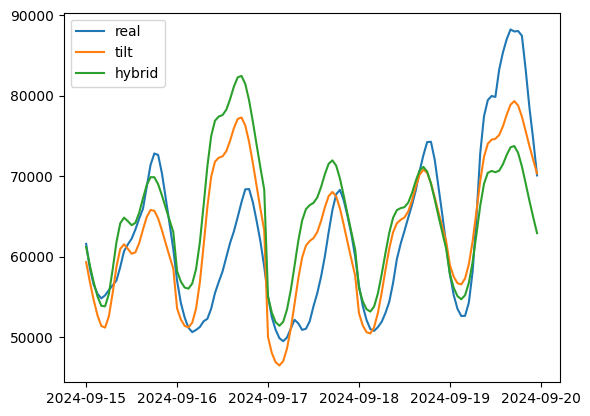

In [51]:
# y	baseline_pred	e_tilt	tilted_pred
plt.plot(hybrid_tilt_1["y"][24*6:], label = "real")
plt.plot(hybrid_tilt_1["tilted_pred"][24*6:], label = "tilt")
plt.plot(hybrid_tilt_1["baseline_pred"][24*6:], label = "hybrid")

plt.legend()

## 

In [69]:
# 전체 결과에 대한 평가지표 생성
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

y_true = hybrid_tilt["y"].values
y_pred_tilt = hybrid_tilt["tilted_pred"].values
y_pred = hybrid_tilt["baseline_pred"].values

print(f"MSE : {np.round(mean_squared_error(y_true, y_pred_tilt), 5)}")
print(f"r2_score : {np.round(r2_score(y_true, y_pred_tilt), 5)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(y_true, y_pred_tilt), 5)}")
print(f"RMSE : {np.round(np.sqrt(mean_squared_error(y_true, y_pred_tilt)), 5)}")

print("위는 틸팅 전 ======================== 아래는 틸팅 후\n")

print(f"MSE : {np.round(mean_squared_error(y_true, y_pred), 5)}")
print(f"r2_score : {np.round(r2_score(y_true, y_pred), 5)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(y_true, y_pred), 5)}")
print(f"RMSE : {np.round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)}")

MSE : 11753301.05689
r2_score : 0.89131
MAPE : 0.03648
RMSE : 3428.30878
위는 틸팅 전 ======================== 아래는 틸팅 후

MSE : 11945562.35257
r2_score : 0.88953
MAPE : 0.03661
RMSE : 3456.23529


In [65]:

y_true1 = hybrid_tilt_1["y"].values
y_pred_tilt1 = hybrid_tilt_1["tilted_pred"].values
y_pred1 = hybrid_tilt_1["baseline_pred"].values

In [67]:
print(f"MSE : {np.round(mean_squared_error(y_true1, y_pred_tilt1), 5)}")
print(f"r2_score : {np.round(r2_score(y_true1, y_pred_tilt1), 5)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(y_true1, y_pred_tilt1), 5)}")

print("위는 틸팅 전 ======================== 아래는 틸팅 후")
print(f"MSE : {np.round(mean_squared_error(y_true1, y_pred1), 5)}")
print(f"r2_score : {np.round(r2_score(y_true1,  y_pred1), 5)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(y_true1,  y_pred1), 5)}")


MSE : 69393890.97527
r2_score : 0.23592
MAPE : 0.10481
위는 틸팅 전======================== 아래는 틸팅 후 
MSE : 74602424.25842
r2_score : 0.17857
MAPE : 0.10829
